In [1]:
import sys
sys.path.append('.')

In [2]:
from DataGen import DataGenerator
from AEGAN import AEGAN
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [3]:
# Hyperparameters
input_dim = (96, 96, 3)
z_dim = 100
disc_x_conv_filters = [16, 32, 32, 64]
disc_x_conv_kernels = [(3, 3), (3, 3), (3, 3), (3, 3)]
disc_x_conv_strides = [(1, 1), (1, 1), (1, 1), (1, 1)]
disc_z_neurons = [32, 16]
gen_conv_filters = [64, 32, 32, 16]
gen_conv_kernels = [(3, 3), (3, 3), (3, 3), (3, 3)]
gen_conv_strides = [(1, 1), (1, 1), (1, 1), (1, 1)]
enc_conv_filters = [16, 32, 64, 128]
enc_conv_kernels = [(3,3), (3,3), (3,3)]
enc_conv_strides = [(1,1), (1,1), (1,1)]
lr = 0.002
batch_size = 256
epochs = 50
sess = tf.function()

In [4]:
experiment_folder = os.path.abspath(os.path.join('..', 'Experimentos'))
model_name = 'AEGAN'
image_path = os.path.abspath(os.path.join('..', 'Dataset'))
data_path = os.path.join(image_path, 'wclasses.csv')

model_path = os.path.abspath(os.path.join(experiment_folder, model_name))
if not os.path.exists(model_path):
    os.mkdir(model_path)

if len(os.listdir(os.path.join(experiment_folder, model_name))) == 0:
    exp_id = 1
else:
    exp_id = len(os.listdir(os.path.join(experiment_folder, model_name))) + 1

current_experiment_path = os.path.join(experiment_folder, model_name, 'Exp_'+str(exp_id))
if not os.path.exists(current_experiment_path):
    os.mkdir(current_experiment_path)

In [5]:
hyperparams = {
    "input_dim":input_dim,
    "z_dim":z_dim,
    "disc_x_conv_filters":disc_x_conv_filters,
    "disc_x_conv_kernels":disc_x_conv_kernels,
    "disc_x_conv_strides":disc_x_conv_strides,
    "disc_z_neurons":disc_z_neurons,
    "gen_conv_filters":gen_conv_filters,
    "gen_conv_kernels":gen_conv_kernels,
    "gen_conv_strides":gen_conv_strides,
    "enc_conv_filters":enc_conv_filters,
    "enc_conv_kernels":enc_conv_kernels,
    "enc_conv_strides":enc_conv_strides,
    "learning rate":lr,
    "batch_size":batch_size,
    "epochs":epochs,
    "opt":"Adam",
    "loss":"binary_crossentropy",
    "data_path":data_path
}

with open(os.path.join(current_experiment_path, 'hyperparams.json'), 'w') as f:
    json.dump(hyperparams, f)

In [6]:
# Train the model
df = pd.read_csv(data_path, sep=',', encoding='ANSI')
# Load data
data_flow = DataGenerator(df, path_to_img=image_path, batch_size=batch_size, width=input_dim[0], height=input_dim[1], channels=input_dim[2], shuffle=True)
gan = AEGAN(input_dim, 
            disc_x_conv_filters, 
            disc_x_conv_kernels, 
            disc_x_conv_strides, 
            disc_z_neurons, 
            gen_conv_filters, 
            gen_conv_kernels, 
            gen_conv_strides, 
            enc_conv_filters, 
            enc_conv_kernels, 
            enc_conv_strides, 
            z_dim, 
            lr)
gan.build(use_dropout=False)



Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 G_Expansion (Dense)         (None, 9216)              930816    
                                                                 
 layer_normalization_4 (Lay  (None, 9216)              18432     
 erNormalization)                                                
                                                                 
 activation (Activation)     (None, 9216)              0         
                                                                 
 reshape (Reshape)           (None, 12, 12, 64)        0         
                                                                 
 G_Upsampling_1 (UpSampling  (None, 24, 24, 64)        0         
 2D)                                                             
                                                                 
 G_Conv_1 (Conv2D)           (None, 24, 24, 64)        

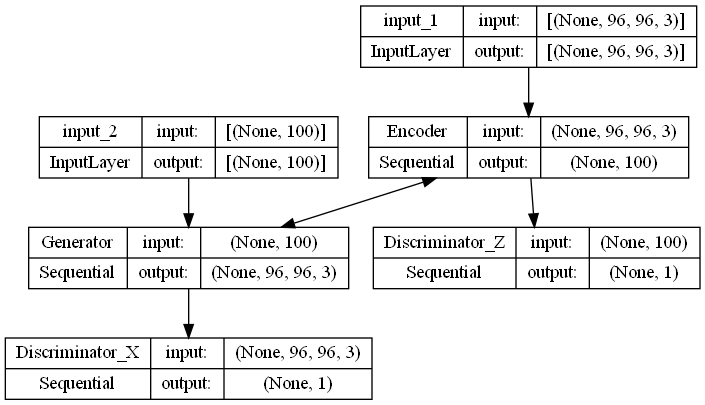

In [7]:
path = os.path.join(current_experiment_path, 'aegan_generator.png')
plot_model(gan.G, to_file=path, show_shapes=True)
path = os.path.join(current_experiment_path, 'aegan_discriminator_x.png')
plot_model(gan.D_x, to_file=path, show_shapes=True)
path = os.path.join(current_experiment_path, 'aegan_encoder.png')
plot_model(gan.E, to_file=path, show_shapes=True)
path = os.path.join(current_experiment_path, 'aegan_discriminator_z.png')
plot_model(gan.D_z, to_file=path, show_shapes=True)
path = os.path.join(current_experiment_path, 'aegan_complete.png')
plot_model(gan.combined, to_file=path, show_shapes=True)

Gx: 3.301791563466355, of 50
Gz: 2.9948138679776872, of 50
Dx: 0.9987376471235764, of 50
Dz: 0.7941214342600136, of 50
Rx: 0.25155992132247523, of 50
Rz: 1.0136823217198838, of 50

Images generated in epoch: 50
1/1 [==============================] - 0s 38ms/step


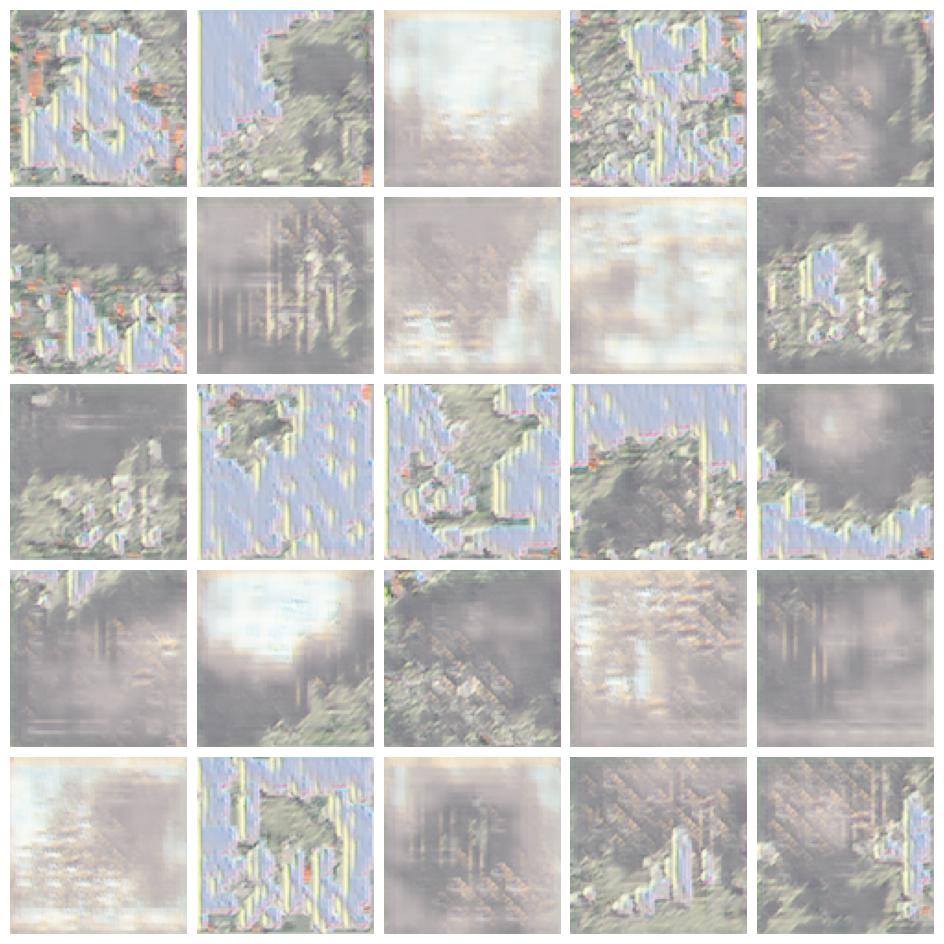


Final Images
1/1 [==============================] - 0s 30ms/step


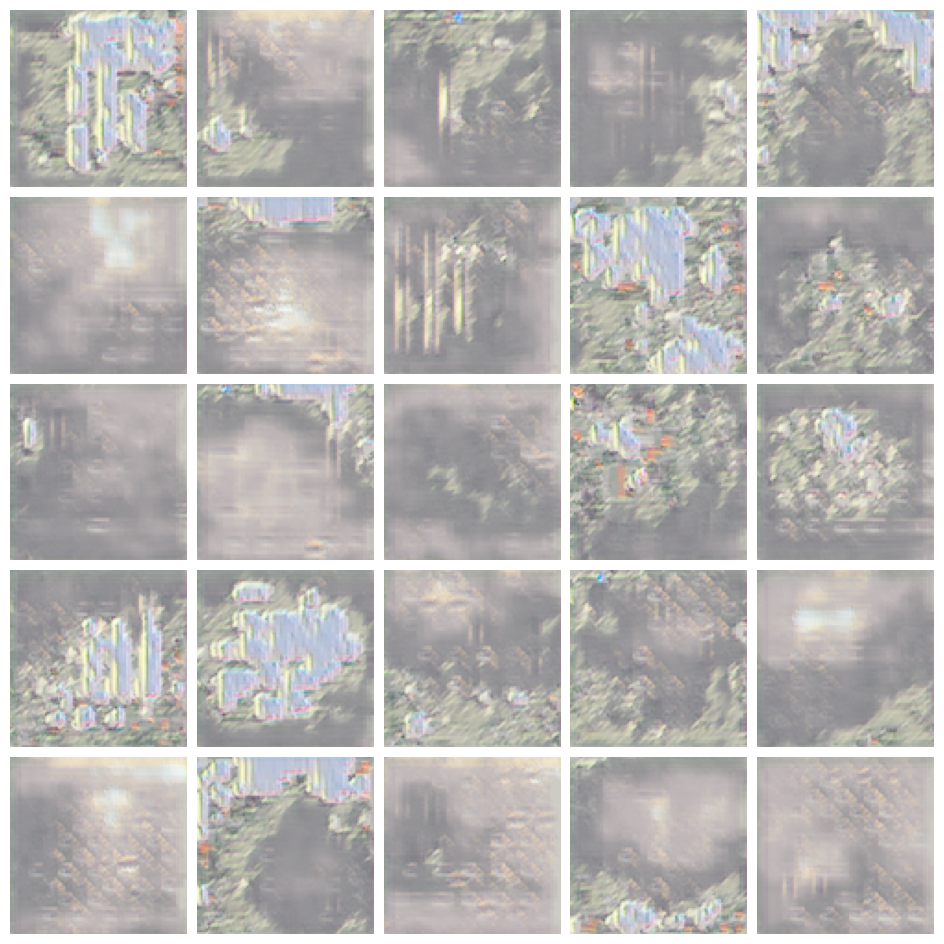

In [9]:
history = gan.train(data_flow, current_experiment_path, epochs=epochs, verbose=True)

1/1 [==============================] - 0s 31ms/step


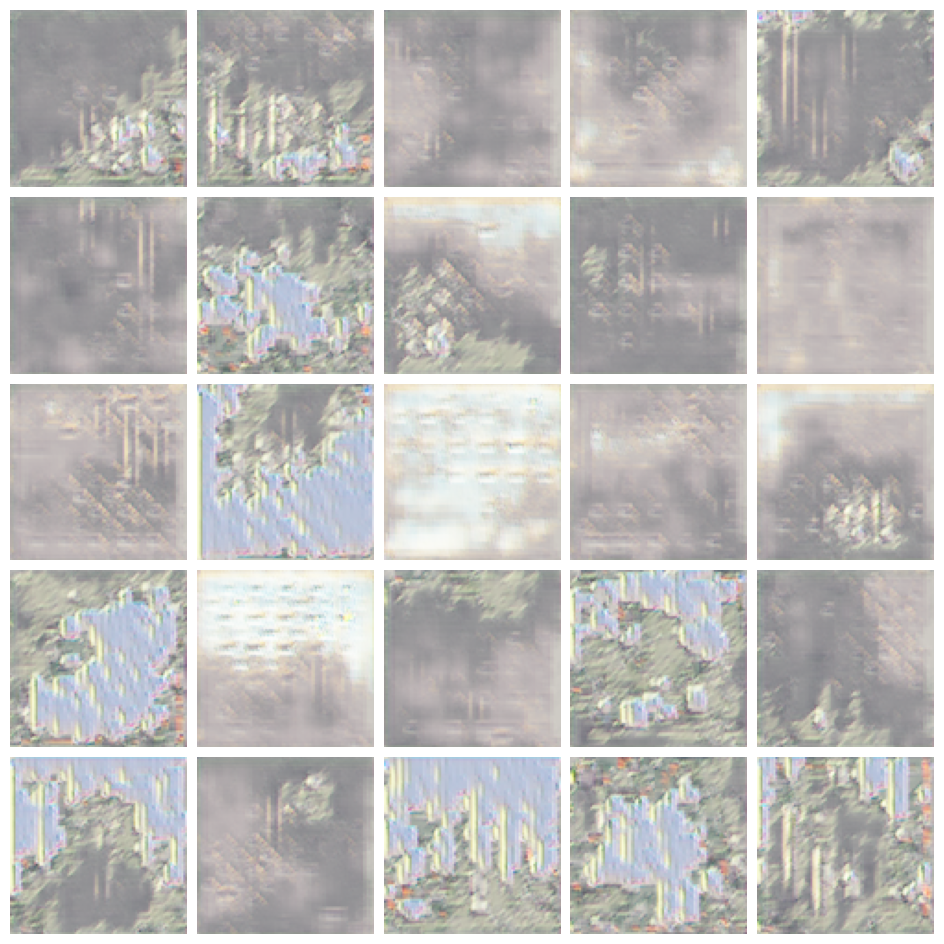

In [11]:
gan._generate(current_experiment_path)

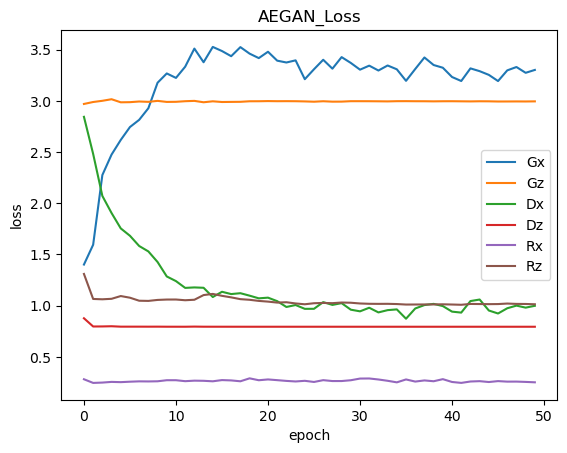

In [13]:
plt.plot(history['Gx'])
plt.plot(history['Gz'])
plt.plot(history['Dx'])
plt.plot(history['Dz'])
plt.plot(history['Rx'])
plt.plot(history['Rz'])
plt.title('AEGAN_Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Gx', 'Gz', 'Dx', 'Dz', 'Rx', 'Rz'])
# guardamos las imágenes
filename = 'aegan_loss.png'
path = os.path.join(current_experiment_path, filename)
plt.savefig(path)
plt.show()
plt.close()